In [13]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
import datetime as dt

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import gc

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans


import folium
import geopandas as gpd
from haversine import haversine
seed = 73

In [14]:
train = pd.read_csv('train.csv') # index_col=0 is the id column
test = pd.read_csv('test.csv') # index_col=0 is the id column
submission = pd.read_csv('sample_submission.csv')


In [15]:
#https://www.kaggle.com/code/dmitryuarov/ps3e20-rwanda-emission-advanced-fe-29-7/notebook
def get_id(row):
    return int(''.join(filter(str.isdigit, str(row['latitude']))) + ''.join(filter(str.isdigit, str(row['longitude']))))

train['id'] = train[['latitude', 'longitude']].apply(lambda row: get_id(row), axis=1)
test['id'] = test[['latitude', 'longitude']].apply(lambda row: get_id(row), axis=1)
new_ids = {id_: new_id for new_id, id_ in enumerate(train['id'].unique())}
train['id'] = train['id'].map(new_ids)
test['id'] = test['id'].map(new_ids)

def get_month(row):
    date = dt.datetime.strptime(f'{row["year"]}-{row["week_no"]+1}-1', "%Y-%W-%w")
    return date.month

rwanda_center = (-1.9607, 29.9707)
park_biega = (-1.8866, 28.4518)
kirumba = (-0.5658, 29.1714)
massif = (-3.42, 28.592)
lake = (-2.0073, 31.6269)

def cluster_features(df, cluster_centers):
    for i, cc in enumerate(cluster_centers.values()):
        df[f'cluster_{i}'] = df.apply(lambda x: haversine((x['latitude'], x['longitude']), cc, unit='ft'), axis=1)
    return df
    
y = train['emission']

def preprocessing(df):
    
    cols_save = ['id', 'latitude', 'longitude', 'year', 'week_no', 'Ozone_solar_azimuth_angle']
    df = df[cols_save]
    
    good_col = 'Ozone_solar_azimuth_angle'
    df[good_col] = df.groupby(['id', 'year'])[good_col].ffill().bfill()
    df[f'{good_col}_lag_1'] = df.groupby(['id', 'year'])[good_col].shift(1).fillna(0)
            
    df['rot_15_x'] = (np.cos(np.radians(15)) * df['longitude']) + \
                     (np.sin(np.radians(15)) * df['latitude'])
    
    df['rot_15_y'] = (np.cos(np.radians(15)) * df['latitude']) + \
                     (np.sin(np.radians(15)) * df['longitude'])

    df['rot_30_x'] = (np.cos(np.radians(30)) * df['longitude']) + \
                     (np.sin(np.radians(30)) * df['latitude'])

    df['rot_30_y'] = (np.cos(np.radians(30)) * df['latitude']) + \
                     (np.sin(np.radians(30)) * df['longitude'])
    
    for col, coors in zip(
        ['dist_rwanda', 'dist_park', 'dist_kirumba', 'dist_massif', 'dist_lake'], 
        [rwanda_center, park_biega, kirumba, massif, lake]
    ):
        df[col] = df.apply(lambda x: haversine((x['latitude'], x['longitude']), coors, unit='ft'), axis=1)
    
    df['month'] = df[['year', 'week_no']].apply(lambda row: get_month(row), axis=1)
    df['is_covid'] = (df['year'] == 2020) & (df['month'] > 2) | (df['year'] == 2021) & (df['month'] == 1)
    df['is_lockdown'] = (df['year'] == 2020) & ((df['month'].isin([3,4])))
            
    df.fillna(0, inplace=True)
    return df
    
train = preprocessing(train)
test = preprocessing(test)

df = pd.concat([train, test], axis=0, ignore_index=True)
coordinates = df[['latitude', 'longitude']].values
clustering = KMeans(n_clusters=12, max_iter=1000, random_state=seed).fit(coordinates)
cluster_centers = {i: tuple(centroid) for i, centroid in enumerate(clustering.cluster_centers_)}
df = cluster_features(df, cluster_centers)

train = df.iloc[:-len(test),:]
test = df.iloc[-len(test):,:]
del df

X = train.drop('id', axis=1)
test = test.drop('id', axis=1)
test=test.reset_index(drop=True)

In [16]:
train.head()

,id,latitude,longitude,year,week_no,Ozone_solar_azimuth_angle,Ozone_solar_azimuth_angle_lag_1,rot_15_x,rot_15_y,rot_30_x,rot_30_y,dist_rwanda,dist_park,dist_kirumba,dist_massif,dist_lake,month,is_covid,is_lockdown,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11
0,0,-0.51,29.29,2019,0,-138.786446,0.000000,28.15997,7.088188,25.110884,14.203327,584571.8739,587934.30305,47814.701579,1.091677e+06,1.012320e+06,1,False,False,248978.294858,708895.202858,816296.557516,754429.120792,568846.078671,476818.94349,557886.253539,808462.719881,835177.508689,234956.616551,957032.617127,504848.790353
1,0,-0.51,29.29,2019,1,-143.097868,-138.786446,28.15997,7.088188,25.110884,14.203327,584571.8739,587934.30305,47814.701579,1.091677e+06,1.012320e+06,1,False,False,248978.294858,708895.202858,816296.557516,754429.120792,568846.078671,476818.94349,557886.253539,808462.719881,835177.508689,234956.616551,957032.617127,504848.790353
2,0,-0.51,29.29,2019,2,-135.364627,-143.097868,28.15997,7.088188,25.110884,14.203327,584571.8739,587934.30305,47814.701579,1.091677e+06,1.012320e+06,1,False,False,248978.294858,708895.202858,816296.557516,754429.120792,568846.078671,476818.94349,557886.253539,808462.719881,835177.508689,234956.616551,957032.617127,504848.790353
3,0,-0.51,29.29,2019,3,-137.489602,-135.364627,28.15997,7.088188,25.110884,14.203327,584571.8739,587934.30305,47814.701579,1.091677e+06,1.012320e+06,1,False,False,248978.294858,708895.202858,816296.557516,754429.120792,568846.078671,476818.94349,557886.253539,808462.719881,835177.508689,234956.616551,957032.617127,504848.790353
4,0,-0.51,29.29,2019,4,-136.448518,-137.489602,28.15997,7.088188,25.110884,14.203327,584571.8739,587934.30305,47814.701579,1.091677e+06,1.012320e+06,2,False,False,248978.294858,708895.202858,816296.557516,754429.120792,568846.078671,476818.94349,557886.253539,808462.719881,835177.508689,234956.616551,957032.617127,504848.790353


In [22]:
# Defining the objective function with Time Series Cross-Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import optuna
import numpy as np
n_trials = 100
n_splits = 5
# df = train
df = train
# target_column_name = 'emission'  

# Separate features (X) and target variable (y)
# X = df.drop(columns=['emission'])  # Replace 'target_column_name' with the actual column name for the target
# y = df['emission']

# X = X.sort_values('start_date_of_week')
y = y.loc[X.index]

def objective_with_tscv(trial):
    # Hyperparameters to be optimized
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)   
        
    }
    
    
# Time Series Cross-Validation (5 splits)
    tscv = TimeSeriesSplit(n_splits= n_splits)
    rmse_scores = []
    
    for train_index, val_index in tscv.split(X):
        X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
        y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]
        
        # Building and training the XGBoost model
        model = xgb.XGBRegressor(**params)
        model.fit(X_train_cv, y_train_cv, eval_set=[(X_val_cv, y_val_cv)], early_stopping_rounds=100, verbose=False)
        
        # Predicting on the validation set
        y_val_pred_cv = model.predict(X_val_cv)
        
        # Calculating RMSE on the validation set
        rmse_cv = np.sqrt(mean_squared_error(y_val_cv, y_val_pred_cv))
        rmse_scores.append(rmse_cv)
    
    # Returning the mean RMSE across all splits
    return np.mean(rmse_scores)

# Creating a new Optuna study object for TSCV
study_tscv = optuna.create_study(direction='minimize')

# Running the optimization with TSCV
study_tscv.optimize(objective_with_tscv, n_trials=n_trials)

# Displaying the best hyperparameters with TSCV
study_tscv.best_params


[I 2023-08-05 15:55:39,495] A new study created in memory with name: no-name-7a79ee08-7521-4066-8ea2-cef0f08dba5c
[I 2023-08-05 15:55:46,398] Trial 0 finished with value: 136.3306540956835 and parameters: {'learning_rate': 0.18490212265593955, 'n_estimators': 694, 'max_depth': 7, 'subsample': 0.8210013868320245, 'colsample_bytree': 0.8868105667364364, 'gamma': 0.6332653763987149, 'reg_alpha': 0.2901119254117659, 'reg_lambda': 0.8584106994899454}. Best is trial 0 with value: 136.3306540956835.
[I 2023-08-05 15:55:54,331] Trial 1 finished with value: 135.76994986215053 and parameters: {'learning_rate': 0.19564139376041556, 'n_estimators': 414, 'max_depth': 6, 'subsample': 0.8505859748732216, 'colsample_bytree': 0.8085624652877339, 'gamma': 0.5855371375414096, 'reg_alpha': 0.19194922694466043, 'reg_lambda': 0.6690971125977568}. Best is trial 1 with value: 135.76994986215053.
[I 2023-08-05 15:55:58,888] Trial 2 finished with value: 131.6712180762812 and parameters: {'learning_rate': 0.0907

KeyboardInterrupt: 

In [ ]:
best_model.save_model("xgboost_model.model")

In [ ]:
# Extracting feature importances
feature_importances = best_model.feature_importances_

# Creating a DataFrame to display feature importances
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sorting by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Displaying the result
print(feature_importances_df)


                                              Feature  Importance
1                                           longitude    0.658876
0                                            latitude    0.144609
3                                             week_no    0.087914
33                          Ozone_solar_azimuth_angle    0.014046
24                 UvAerosolIndex_solar_azimuth_angle    0.011137
41                               Cloud_surface_albedo    0.007585
10                 CarbonMonoxide_solar_azimuth_angle    0.006894
34                           Ozone_solar_zenith_angle    0.004893
26                     Ozone_O3_column_number_density    0.004695
25                  UvAerosolIndex_solar_zenith_angle    0.003976
21                     UvAerosolIndex_sensor_altitude    0.003606
38                          Cloud_cloud_base_pressure    0.003567
44                          Cloud_solar_azimuth_angle    0.003495
11                  CarbonMonoxide_solar_zenith_angle    0.003011
17        

In [183]:
# !pip install shap
import shap

# Explain the model's predictions using SHAP
explainer = shap.Explainer(best_model)
shap_values = explainer(X)


In [ ]:
# Summary plot
shap.summary_plot(shap_values, X)

In [ ]:
# Example for the first observation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])


In [ ]:
# {'learning_rate': 0.1480866304651673,
#  'n_estimators': 872,
#  'max_depth': 9,
#  'subsample': 0.9680697912136806,
#  'colsample_bytree': 0.9567556826297667,
#  'gamma': 0.9508685494078148,
#  'reg_alpha': 0.9865087715254304,
#  'reg_lambda': 0.5871491268150437}

In [106]:
import optuna.visualization as vis

vis.plot_optimization_history(study_tscv)


In [108]:
vis.plot_param_importances(study_tscv)

In [112]:
optuna.visualization.plot_slice(study_tscv)

In [115]:
optuna.visualization.plot_parallel_coordinate(study_tscv)

<Figure size 4000x2000 with 0 Axes>

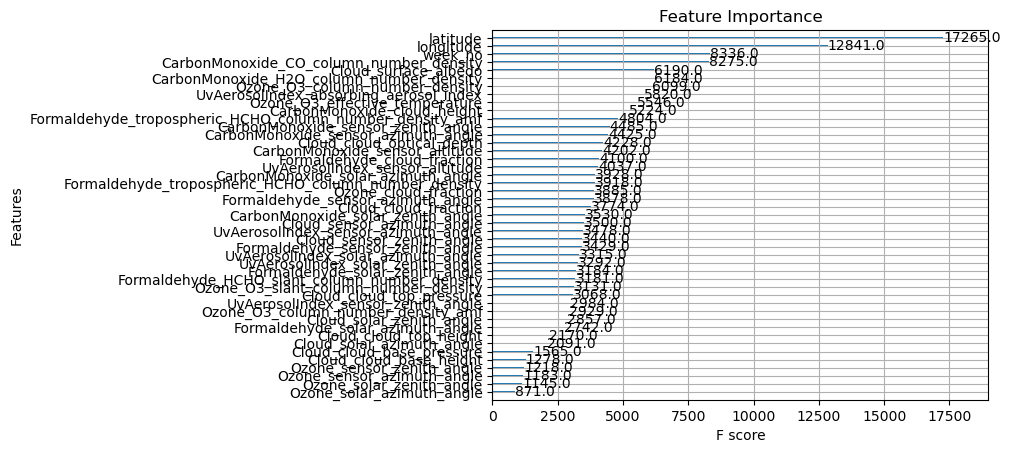

In [178]:
# Train the XGBoost model with the best parameters obtained from Optuna
best_params = study_tscv.best_params
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X, y)

# Plot the feature importance
plt.figure(figsize=(40, 20))
xgb.plot_importance(best_model)
plt.title('Feature Importance')
plt.show()
